In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from matplotlib import pyplot as plt

In [49]:
df = pd.read_csv('Diabetes Classification.csv', index_col=0)

In [50]:
categorical = ['Gender']
numerical = ['Age','BMI','Chol','TG','HDL','LDL','Cr','BUN']

### Exploratory Data Analysis

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5132 entries, 0 to 5131
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        5132 non-null   int64  
 1   Gender     5132 non-null   object 
 2   BMI        5132 non-null   int64  
 3   Chol       5132 non-null   float64
 4   TG         5132 non-null   float64
 5   HDL        5132 non-null   float64
 6   LDL        5132 non-null   float64
 7   Cr         5132 non-null   float64
 8   BUN        5132 non-null   float64
 9   Diagnosis  5132 non-null   int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 441.0+ KB


In [52]:
df.describe()

,Age,BMI,Chol,TG,HDL,LDL,Cr,BUN,Diagnosis
count,5132.000000,5132.000000,5132.000000,5132.000000,5132.000000,5132.000000,5132.000000,5132.000000,5132.000000
mean,48.950312,24.613406,4.866882,1.719328,1.593305,2.914121,71.144800,4.896969,0.388348
std,14.048794,4.277205,1.001052,1.327057,1.038849,0.945423,28.494394,1.689206,0.487422
min,20.000000,15.000000,0.000000,0.000000,0.000000,0.300000,4.860753,0.500000,0.000000
25%,36.000000,22.000000,4.190000,0.910000,1.090000,2.290000,58.000000,3.900000,0.000000
50%,49.000000,24.000000,4.800000,1.380000,1.300000,2.790000,70.200000,4.720000,0.000000
75%,59.000000,27.000000,5.460000,2.100000,1.590000,3.400000,81.600000,5.600000,1.000000
max,93.000000,47.000000,11.650000,32.640000,9.900000,9.900000,800.000000,38.900000,1.000000


In [53]:
df.isna().sum()

Age          0
Gender       0
BMI          0
Chol         0
TG           0
HDL          0
LDL          0
Cr           0
BUN          0
Diagnosis    0
dtype: int64

In [54]:
df.nunique()

Age           71
Gender         3
BMI           29
Chol         513
TG           495
HDL          206
LDL          409
Cr           742
BUN          616
Diagnosis      2
dtype: int64

In [55]:
df['Gender'].unique()

array(['F', 'M', 'f'], dtype=object)

In [56]:
df['Gender'] = df['Gender'].str.upper()

Text(0.5, 1.0, 'Target Distribution')

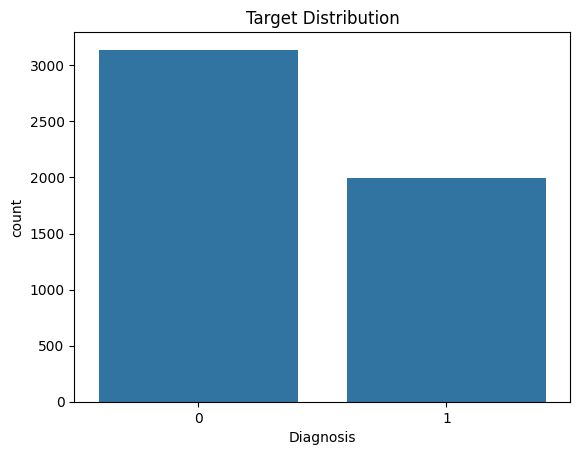

In [57]:
sns.countplot(x='Diagnosis', data=df)
plt.title('Target Distribution')

In [58]:
df[numerical + ['Diagnosis']].corr()['Diagnosis'].sort_values(ascending=False)

Diagnosis    1.000000
Age          0.524570
BMI          0.427543
HDL          0.309579
TG           0.241759
LDL          0.230578
BUN          0.132749
Chol         0.131169
Cr          -0.037298
Name: Diagnosis, dtype: float64

## Train Models

In [59]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.Diagnosis.values
y_val = df_val.Diagnosis.values
y_test = df_test.Diagnosis.values

del df_train['Diagnosis']
del df_val['Diagnosis']
del df_test['Diagnosis']

In [60]:
dv = DictVectorizer()

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [62]:
params = {'C': [1, 10, 100, 1000]}
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=1)
grid_search = GridSearchCV(model, params, scoring='f1')
grid_search.fit(X_train, y_train)

best_logreg = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)
print("Best F1:", grid_search.best_score_)

Best params: {'C': 100}
Best F1: 0.7436712960146019


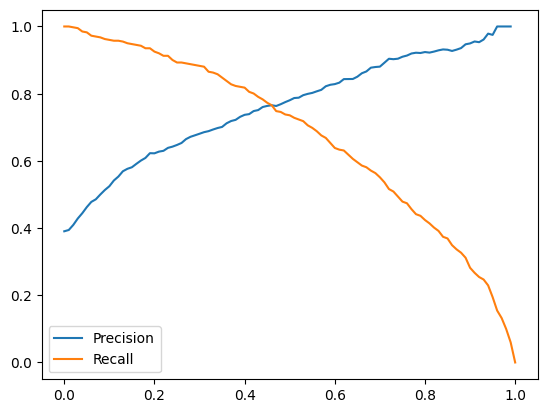

In [63]:
scores = []

y_pred = best_logreg.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))


columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [64]:
diagnosis_decision = (y_pred >= 0.42)

logreg_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': round(accuracy_score(y_val, diagnosis_decision),3),
    'Precision': round(precision_score(y_val, diagnosis_decision),3),
    'Recall': round(recall_score(y_val, diagnosis_decision),3),
    'F1': round(f1_score(y_val, diagnosis_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in logreg_metrics.items():
    print(f"{k}: {v}")

Model: Logistic Regression
Accuracy: 0.817
Precision: 0.748
Recall: 0.8
F1: 0.773
AUC: 0.892


### Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
params = {
    'max_depth': [1,2,3,5,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4]
}
dt = DecisionTreeClassifier(random_state=1)
grid_search = GridSearchCV(dt,params,scoring='f1')
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)
print("Best F1:", grid_search.best_score_)

Best params: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1: 0.7733754110773773


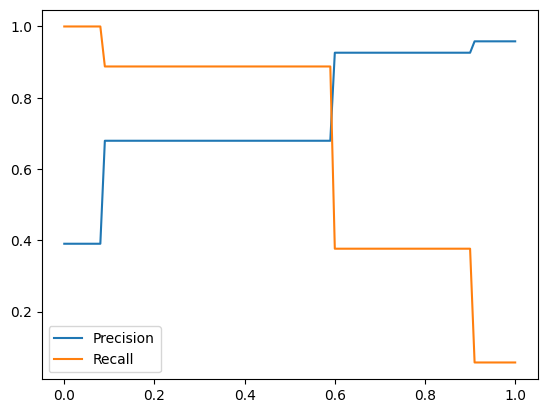

In [67]:
scores = []

y_pred = best_dt.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))


columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [71]:
diagnosis_decision = (y_pred >= 0.5)

dt_metrics = {
    'Model': 'Decision Tree',
    'Accuracy': round(accuracy_score(y_val, diagnosis_decision),3),
    'Precision': round(precision_score(y_val, diagnosis_decision),3),
    'Recall': round(recall_score(y_val, diagnosis_decision),3),
    'F1': round(f1_score(y_val, diagnosis_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in dt_metrics.items():
    print(f"{k}: {v}")

Model: Decision Tree
Accuracy: 0.793
Precision: 0.679
Recall: 0.888
F1: 0.77
AUC: 0.852


### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
params = {
    'n_estimators': [200,300,400],
    'max_depth':[15,20,25,None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2,5,10,15]
}
rf = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(rf,params,scoring='f1')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)
print("Best F1:", grid_search.best_score_)

Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
Best F1: 0.773195937066622


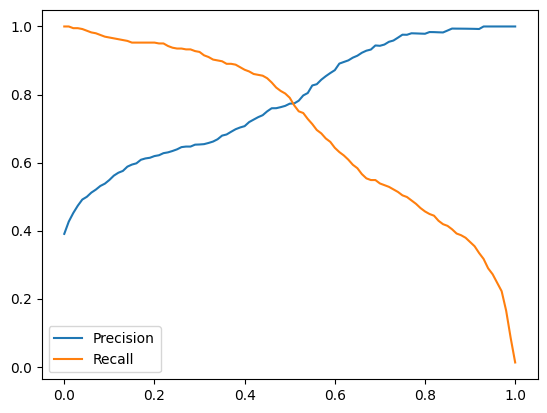

In [41]:
scores = []
y_pred = best_rf.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))


columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [40]:
diagnosis_decision = (y_pred >= 0.45)

rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': round(accuracy_score(y_val, diagnosis_decision),3),
    'Precision': round(precision_score(y_val, diagnosis_decision),3),
    'Recall': round(recall_score(y_val, diagnosis_decision),3),
    'F1': round(f1_score(y_val, diagnosis_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in rf_metrics.items():
    print(f"{k}: {v}")

Model: Random Forest
Accuracy: 0.831
Precision: 0.751
Recall: 0.848
F1: 0.796
AUC: 0.914


### Gradient Boosting

In [72]:
from xgboost import XGBClassifier

In [73]:
params = {
    'n_estimators': [100,200,300],
    'max_depth':[3,5,7,10,None],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8,1.0]
}
xgb = XGBClassifier(random_state=1, eval_metric='logloss')
grid_search = GridSearchCV(xgb,params,scoring='f1')
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)
print("Best F1:", grid_search.best_score_)

Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best F1: 0.7674390913054203


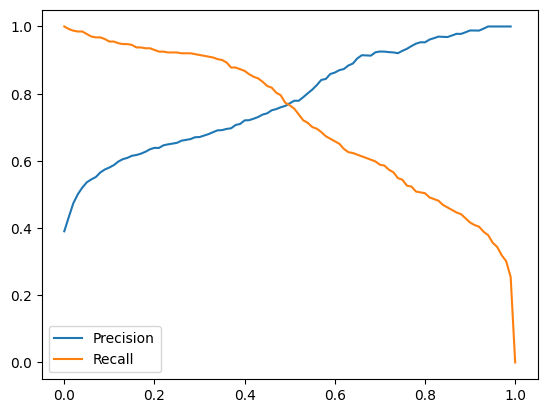

In [74]:
scores = []
y_pred = best_xgb.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))


columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [76]:
diagnosis_decision = (y_pred >= 0.46)

xgb_metrics = {
    'Model': 'Gradient Boosting',
    'Accuracy': round(accuracy_score(y_val, diagnosis_decision),3),
    'Precision': round(precision_score(y_val, diagnosis_decision),3),
    'Recall': round(recall_score(y_val, diagnosis_decision),3),
    'F1': round(f1_score(y_val, diagnosis_decision),3),
    'AUC': round(roc_auc_score(y_val, y_pred),3)
}
for k,v in xgb_metrics.items():
    print(f"{k}: {v}")

Model: Gradient Boosting
Accuracy: 0.823
Precision: 0.751
Recall: 0.818
F1: 0.783
AUC: 0.91


## Feature Importance

In [77]:
model = RandomForestClassifier(random_state=1, max_depth=20, max_features='sqrt', min_samples_split=10, n_estimators=300)
model.fit(X_train,y_train)

feature_importance = pd.DataFrame({'feature': dv.get_feature_names_out(), 'importance': model.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False).head()

,feature,importance
0,Age,0.348064
7,HDL,0.144759
1,BMI,0.118077
8,LDL,0.116919
9,TG,0.079997


### Model Selection

In [78]:
df_metrics = pd.DataFrame([logreg_metrics, dt_metrics, rf_metrics, xgb_metrics])
df_metrics

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.817,0.748,0.800,0.773,0.892
1,Decision Tree,0.793,0.679,0.888,0.770,0.852
2,Random Forest,0.831,0.751,0.848,0.796,0.914
3,Gradient Boosting,0.823,0.751,0.818,0.783,0.910
